In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 50)

# Обзор данных

In [58]:
df = pd.read_csv('stud_math.xls')  # Загружаем датасет для дальнейшей работы
print("Первоначальный размер датасета : {}".format(df.shape))
data = df.copy()
display(data.sample(5))
data.info()

Первоначальный размер датасета : (395, 30)


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
81,GP,M,15,U,GT3,NaN,2.0,3.0,other,other,home,NaN,1.0,3.0,0.0,yes,no,NaN,NaN,no,-9.0,yes,yes,no,5.0,3.0,2.0,5.0,4.0,55.0
273,GP,M,17,R,GT3,T,1.0,2.0,at_home,at_home,home,mother,1.0,2.0,0.0,no,yes,yes,yes,no,-6.0,yes,NaN,yes,3.0,5.0,2.0,1.0,2.0,70.0
151,GP,M,16,U,LE3,T,2.0,1.0,at_home,NaN,course,mother,1.0,1.0,1.0,NaN,no,no,yes,yes,-3.0,yes,no,yes,4.0,4.0,4.0,5.0,6.0,70.0
116,GP,M,15,U,GT3,T,4.0,4.0,other,teacher,reputation,father,2.0,2.0,0.0,no,yes,no,NaN,yes,-6.0,yes,no,no,4.0,4.0,3.0,2.0,2.0,70.0
271,GP,F,18,U,GT3,NaN,2.0,3.0,other,services,reputation,father,1.0,4.0,0.0,no,NaN,yes,yes,yes,-12.0,yes,yes,yes,4.0,5.0,5.0,2.0,4.0,70.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

**Описание признаков из датасета:**
- school — аббревиатура школы, в которой учится ученик
- sex — пол ученика ('F' - женский, 'M' - мужской)
- age — возраст ученика (от 15 до 22)
- address — тип адреса ученика ('U' - городской, 'R' - за городом)
- famsize — размер семьи('LE3' <= 3, 'GT3' >3)
- Pstatus — статус совместного жилья родителей ('T' - живут вместе 'A' - раздельно)
- Medu — образование матери (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
- Fedu — образование отца (0 - нет, 1 - 4 класса, 2 - 5-9 классы, 3 - среднее специальное или 11 классов, 4 - высшее)
- Mjob — работа матери ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
- Fjob — работа отца ('teacher' - учитель, 'health' - сфера здравоохранения, 'services' - гос служба, 'at_home' - не работает, 'other' - другое)
- reason — причина выбора школы ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа, 'other' - другое)
- guardian — опекун ('mother' - мать, 'father' - отец, 'other' - другое)
- traveltime — время в пути до школы (1 - <15 мин., 2 - 15-30 мин., 3 - 30-60 мин., 4 - >60 мин.)
- studytime — время на учёбу помимо школы в неделю (1 - <2 часов, 2 - 2-5 часов, 3 - 5-10 часов, 4 - >10 часов)
- failures — количество внеучебных неудач (n, если 1<=n<=3, иначе 0)
- schoolsup — дополнительная образовательная поддержка (yes или no)
- famsup — семейная образовательная поддержка (yes или no)
- paid — дополнительные платные занятия по математике (yes или no)
- activities — дополнительные внеучебные занятия (yes или no)
- nursery — посещал детский сад (yes или no)
- higher — хочет получить высшее образование (yes или no)
- internet — наличие интернета дома (yes или no)
- romantic — в романтических отношениях (yes или no)
- famrel — семейные отношения (от 1 - очень плохо до 5 - очень хорошо)
- freetime — свободное время после школы (от 1 - очень мало до 5 - очень мого)
- goout — проведение времени с друзьями (от 1 - очень мало до 5 - очень много)
- health — текущее состояние здоровья (от 1 - очень плохо до 5 - очень хорошо)
- absences — количество пропущенных занятий
- score — баллы по госэкзамену по математике (целевая переменная)

<AxesSubplot:>

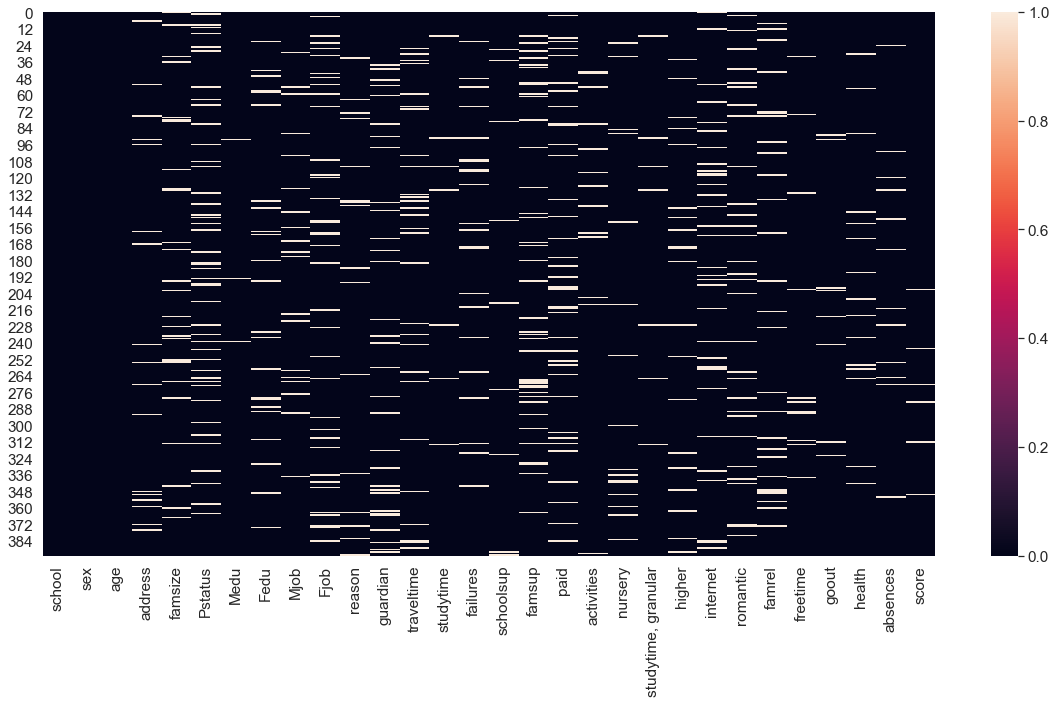

In [59]:
# Тепловая карта "пустых" значений (т.е. Nan). Белые полоски - пропуски в данных
# Наша первостепенная цель - избавиться от этих пустых значений
plt.subplots(figsize=(20, 10))
sns.heatmap(data.isnull())

<AxesSubplot:>

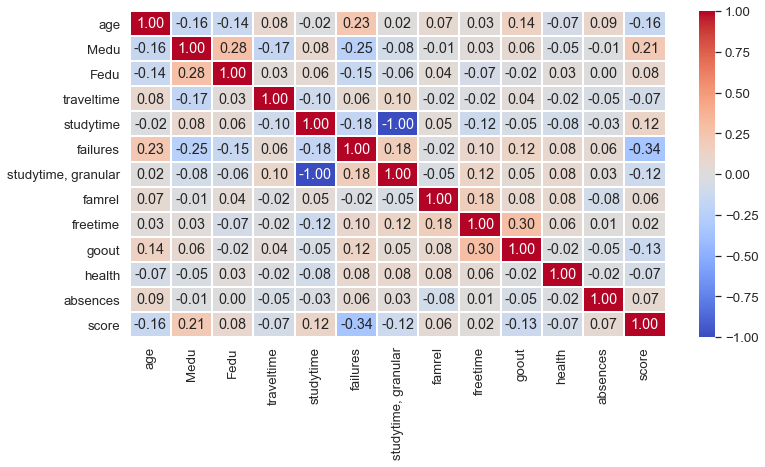

In [60]:
# Посмотрим на матрицу корреляций признаков
sns.set(font_scale=1.2)
plt.subplots(figsize=(12, 6))
sns.heatmap(data.corr(), annot=True, fmt='.2f', linewidths=0.1, cmap="coolwarm")

Видно, что коэфф. корреляция между "studytime, granular" и  "studytime" равен -1, что говорит нам о том, что эти данные по сути показывают одну и ту же информацию. Удалим один из этих столбцов

In [61]:
# Удаляем этот, так как совсем не понятно, что он обозначает - нет описания
data.drop('studytime, granular', axis=1, inplace=True)

In [62]:
# Проверяем, где есть пропуски и дубликаты
print("Дубликатов найдено:", data.duplicated(keep=False).sum())
print("Пропусков найдено:", data.isnull().sum().sum())

Дубликатов найдено: 0
Пропусков найдено: 558


395 строк. Видно, в каких столбцах есть пустые значения и сколько их. 
С помощью функции чуть позже заменим пропуски в некоторых столбцах (где тип данных - объект) и подробнее изучим каждый столбец

# Дополнительные функции для удобства дальнейшей работы

In [63]:
# Создадим список, куда будем добавлять имена признаков, отобранные для дальнейшей работы при построении модели
features_for_the_model = []


def no_info(column):
    '''Функция заменяет пропуски в выбранном столбце на "no_info"'''
    data[column] = data[column].fillna(value='no_info')


# Применим эту функцию для некоторых категориальных признаков
no_info(['address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian',
         'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic'])


def nan_to_median(column):
    '''Функция заменяет пропуски на медианные данные в числовом столбце'''
    data[column].fillna(value=data[column].median(), inplace=True)


def nan_to_mode(column):
    '''Функция заменяет пропуски на моду в числовом столбце'''
    data[column].fillna(value=data[column].mode()[0], inplace=True)


def IQR_for_column(column):
    """Функция возвращает квартили, выводит границы для выбросов, согласно IQR и 
    считает сколько выбросов (в том числе в %)"""
    perc25 = data[column].quantile(0.25)
    perc75 = data[column].quantile(0.75)
    IQR = perc75 - perc25
    min_out = perc25 - 1.5*IQR
    max_out = perc75 + 1.5*IQR
    anomaly = len(data[data[column] > max_out]) + \
        len(data[data[column] < min_out])
    print(
        '25-й перцентиль: {} |'.format(perc25),
        '75-й перцентиль: {} |'.format(perc75),
        "IQR: {} | ".format(IQR),
        "Границы выбросов: [{}, {}].".format(min_out, max_out))
    print("Выбросов, согласно IQR: {} | {:2.2%}".format(
        anomaly, anomaly/len(data)))

In [64]:
def boxplot_for_cat(column, describe, figsize=(16, 3)):
    """Функция для создания boxplot для категориального признака"""
    sns.set(font_scale=1.4)
    plt.subplots(figsize=figsize)
    plt.xticks(ticks=range(0, 101, 5))
    plt.title('Распределение оценок в зависимости от ' + describe)
    sns.boxplot(y=column, x=data.score, color='royalblue', orient='h')
    plt.xlabel('Количество баллов')


def histplot_for_cat(column, bins='auto', figsize=(3, 3)):
    """Функция для создания гистограммы для категориального признака"""
    sns.set(font_scale=1.25)
    plt.figure(figsize=figsize)
    plt.ylabel('Количество учеников')
    sns.histplot(column, color='royalblue', bins=bins, discrete=True)


def get_stat_dif(column):
    """Функция для поиска статистически значимых различий для колонок"""
    cols = data.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(data.loc[data.loc[:, column] == comb[0], 'score'],
                     data.loc[data.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

# Изучаем данные в каждом столбце отдельно

## score - наша целевая переменная

25-й перцентиль: 40.0 | 75-й перцентиль: 70.0 | IQR: 30.0 |  Границы выбросов: [-5.0, 115.0].
Выбросов, согласно IQR: 0 | 0.00%
Всего у 6 учеников не известно оценки


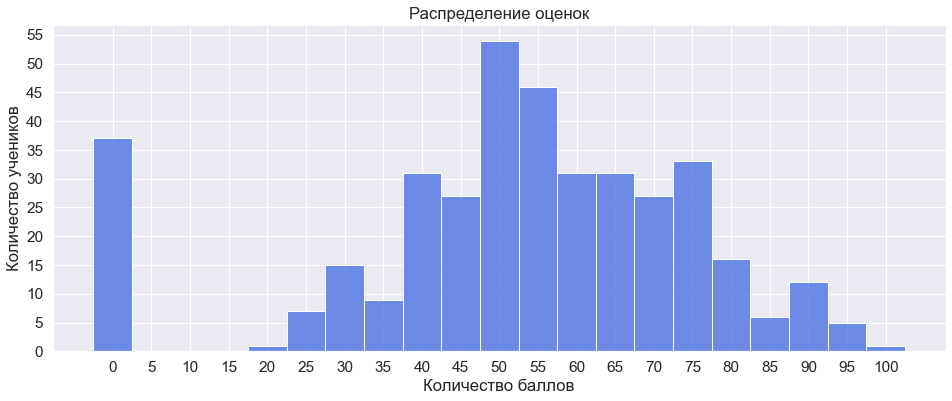

In [65]:
IQR_for_column('score')
print('Всего у {} учеников не известно оценки'.format(data.score.isnull().sum()))

# Посмотрим на распределение оценок
sns.set(font_scale=1.4)
plt.figure(figsize=(16, 6))
plt.yticks(ticks=range(0, 60, 5))
plt.xticks(ticks=range(0, 105, 5))
plt.title('Распределение оценок')
plt.xlabel('Количество баллов')
plt.ylabel('Количество учеников')
sns.histplot(data.score, discrete=True, shrink=5, color='royalblue')
plt.show()

У 37-ми человек оценка "0" и они похожи на выбросы (выбиваются из картины нормального распредения), хоть по IQR нельзя назвать выбросами. Но удалять их нельзя, посколько не известно, что это значит (и правда 0 баллов, неявка, списывание или т.п.).

Шесть значений отсутствуют. Эти оценки - самые важные данные, поэтому можно смело удалять такие строчки с Nan

In [66]:
# Удаляем строки, в который в столбце score нет информации
data.dropna(subset=['score'], inplace=True)

## school

Всего у 0 учеников не известно школы


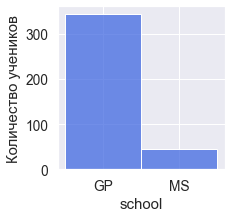

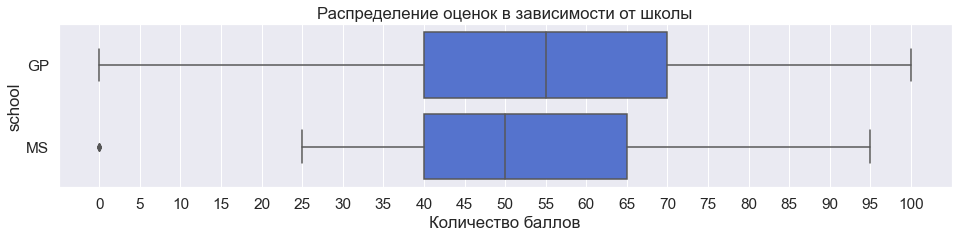

In [67]:
histplot_for_cat(data.school)
print('Всего у {} учеников не известно школы'.format(data.school.isnull().sum()))
# Посмотрим на распределение оценок от значений признака
boxplot_for_cat(data.school, 'школы')

Пропущенные значения и ошибки не наблюдаются. Явной зависимости оценок от школы не заметно.

## sex

Пропущенные значения и ошибки не наблюдаются

Всего у 0 учеников не известно пола


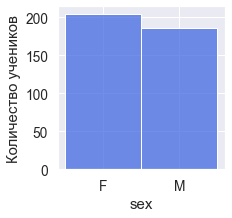

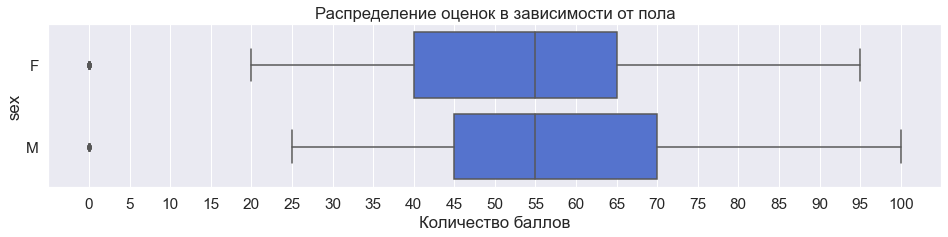

In [68]:
histplot_for_cat(data.sex)
print('Всего у {} учеников не известно пола'.format(data.sex.isnull().sum()))
boxplot_for_cat(data.sex, 'пола')

Пропущеных значений и ошибок нет. Глядя на boxplot можно сделать, что мальчики чуть лучше сдают экзамен, сильно сильно пол не зависит на оценку

## age

16    103
17     98
15     82
18     80
19     21
20      3
22      1
21      1
Name: age, dtype: int64

Всего у 0 учеников не известен возраст
25-й перцентиль: 16.0 | 75-й перцентиль: 18.0 | IQR: 2.0 |  Границы выбросов: [13.0, 21.0].
Выбросов, согласно IQR: 1 | 0.26%


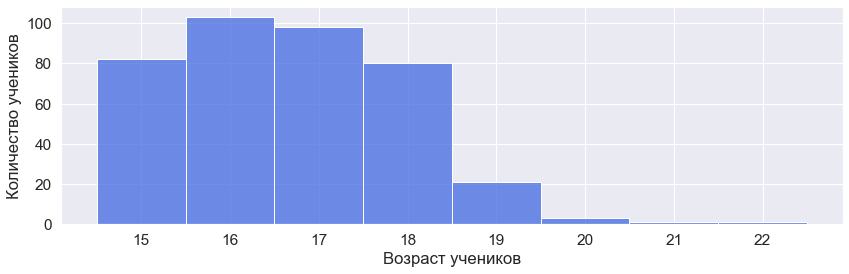

In [69]:
# Проверяем, если ли пропущенные значения и ошибки в столбце возраста
display(data.age.value_counts())
print('Всего у {} учеников не известен возраст'.format(data.age.isnull().sum()))
IQR_for_column('age')

# Посмотрим на распределение по возрасту
sns.set(font_scale=1.4)
plt.figure(figsize=(14, 4))
plt.xlabel('Возраст учеников')
plt.ylabel('Количество учеников')
sns.histplot(data.age, discrete=True, color='royalblue')
plt.show()

Пропущенные значения и ошибки не наблюдаются

Есть всего 5 детей, чей возраст больше 19. На данный момент не вижу причины считать их выбросами и  не учитывать при дальнейшем построении модели (хоть и IQR показывается, что 22 - это выброс). И первоначальная цель проекта - 'отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет'

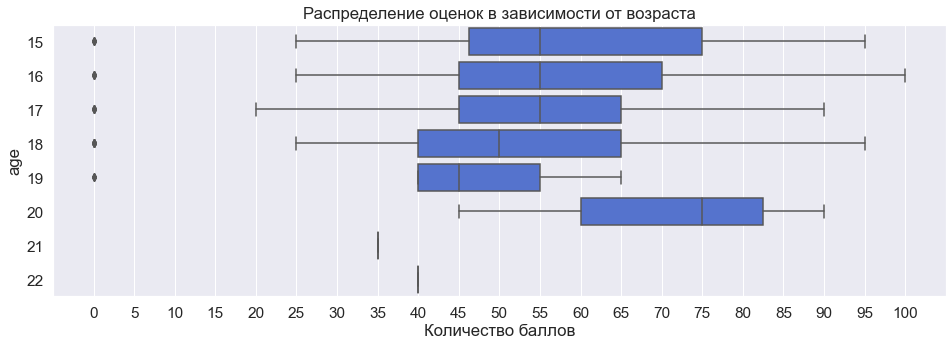

In [70]:
# Раз всe ученики с 15 лет по 22, то можем глянуть на распределение оценок от возраста
boxplot_for_cat(data.age, 'возраста', figsize=(16, 5))

## address

Всего у 15 учеников не известно адреса


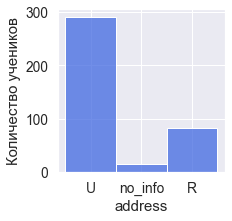

In [71]:
histplot_for_cat(data.address)
print('Всего у {} учеников не известно адреса'.format(
    len(data[data.address == 'no_info'])))

Можно предположить, что те, кто живут за городом тратят времени на дорогу в школу больше часа. 

In [72]:
# Смотрим на медиану данных о времени поездки в школу
data.traveltime.median()

1.0

Медиана равна 1, что очень хорошо, поскольку признак по факту категориальный. Заменим пустые значения в столце времени пути на медиану и посмотрим значение для учеников, для которых отсутствует информация о типе адреса

In [73]:
nan_to_median('traveltime')
data[data['address'] == 'no_info'].traveltime

6      1.0
52     2.0
75     1.0
92     1.0
96     2.0
159    1.0
168    1.0
241    1.0
254    1.0
292    1.0
348    1.0
354    2.0
359    2.0
372    1.0
376    2.0
Name: traveltime, dtype: float64

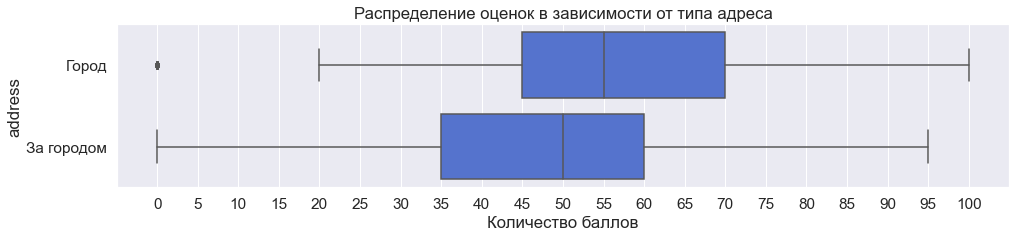

In [74]:
data.loc[data['address'] == 'no_info', 'address'] = 'U'
data.address = data.address.apply(
    lambda x: 'Город' if x == 'U' else 'За городом')
boxplot_for_cat(data.address, 'типа адреса')

Можно заметить, что те кто живут за городом имеют меньше баллов. Поэтому внесём этот признак в список признаков для дальшейшей работы при построении модели.

In [75]:
features_for_the_model.append('address')

## famsize

Всего у 27 учеников не известен размер семьи


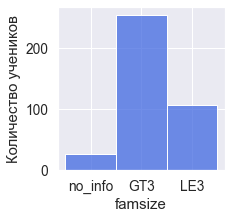

In [76]:
histplot_for_cat(data.famsize)
print('Всего у {} учеников не известен размер семьи'.format(
    len(data[data.famsize == 'no_info'])))

Заменим эти значения на моду (т.е. GT3), это чуть меньше отразится на процентную разницу между данными о размере семьи. И переименуем значения для лучшего понимания

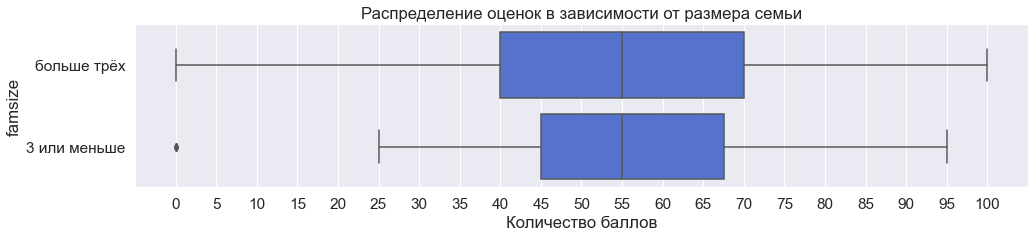

In [77]:
data.loc[data['famsize'] == 'no_info', 'famsize'] = 'GT3'
data.famsize = data.famsize.apply(
    lambda x: "3 или меньше" if x == 'LE3' else 'больше трёх')
boxplot_for_cat(data.famsize, 'размера семьи')

Каких либо выводов о зависимости оценок от размера семьи нельзя сделать

## Pstatus

Всего у 45 учеников не известен статус жительства родителей


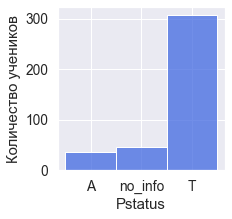

In [78]:
histplot_for_cat(data.Pstatus)
print('Всего у {} учеников не известен статус жительства родителей'.format(
    len(data[data.Pstatus == 'no_info'])))

Отсутсвуют данные о статусе совместного проживания родителей 45-и учеников (это 11,4% от общего количества). На мой взгляд не корректно это данные относить к совместному проживанию или отдельному (будет большая разница в конечном результате при дальнейшем исследовании этих двух вариантов)

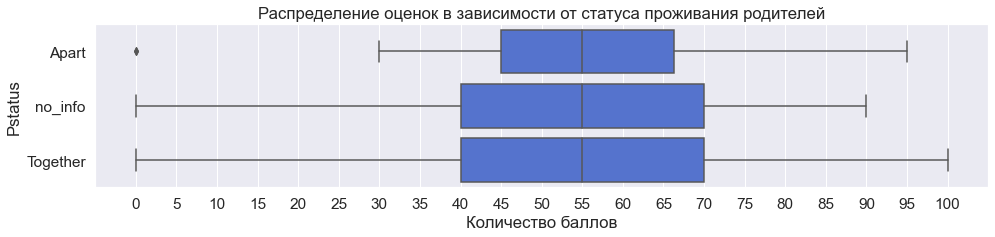

In [79]:
data.Pstatus = data.Pstatus.apply(
    lambda x: 'Together' if x == 'T' else 'Apart' if x == 'A' else x)
boxplot_for_cat(data.Pstatus, 'статуса проживания родителей')

Каких либо выводов о зависимости оценок от проживания родителей нельзя сделать

## Medu

Всего у 3 учеников не известно образование матери


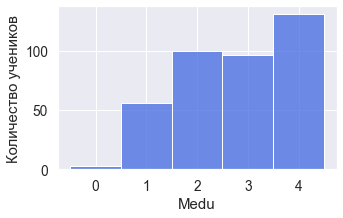

In [80]:
histplot_for_cat(data.Medu, bins=5, figsize=(5, 3))
print('Всего у {} учеников не известно образование матери'.format(
    data.Medu.isnull().sum()))

Заменим эти пустые данные на моду этого столбца и переименуем данные для лучшего восприятия

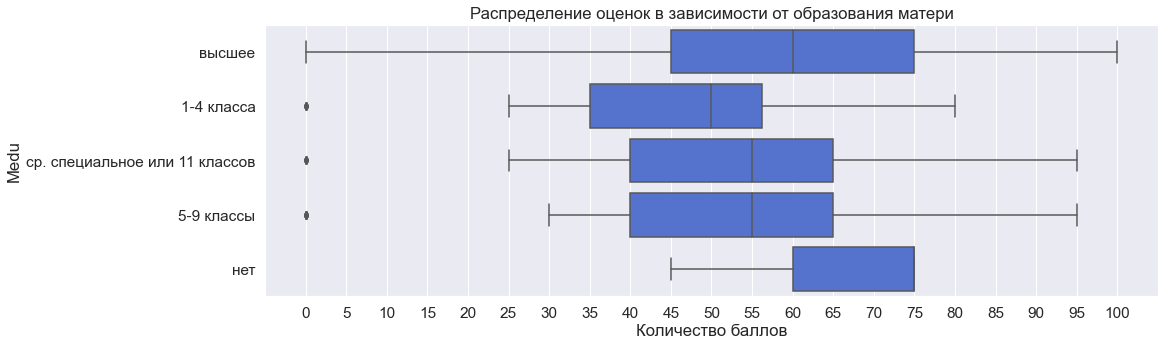

In [81]:
nan_to_mode('Medu')
data.Medu = data.Medu.apply(lambda x: 'нет' if x == 0 else
                            '1-4 класса' if x == 1 else
                            '5-9 классы' if x == 2 else
                            'ср. специальное или 11 классов' if x == 3 else
                            'высшее')
boxplot_for_cat(data.Medu, 'образования матери', figsize=(16, 5))

Видим, что можно заметим небольшую зависимость оценки от образования матери, поэтому внесём эту характеристику к список признаков

In [82]:
features_for_the_model.append('Medu')

## Fedu 

In [83]:
display(data.Fedu.value_counts())
print('Всего у {} учеников не известно образование отца'.format(
    data.Fedu.isnull().sum()))

2.0     105
3.0      94
4.0      88
1.0      75
0.0       2
40.0      1
Name: Fedu, dtype: int64

Всего у 24 учеников не известно образование отца


In [84]:
# Одна явная ошибка (значение 40). Посмотрим на данные об объекте внимательнее
data[data['Fedu'] > 4]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
11,GP,F,15,Город,больше трёх,no_info,5-9 классы,40.0,services,other,reputation,father,3.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0


У этого же ученика отсутствует данные о статусе совместного жилья родителей, все остальные столбцы в порядке. Будем считать, что случилась опечатка, и вместо "4" напечатали "40". Изменим данное значение

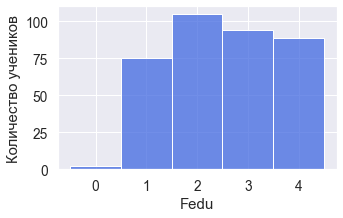

In [85]:
data.loc[data['Fedu'] == 40, 'Fedu'] = 4
histplot_for_cat(data.Fedu, bins=5, figsize=(5, 3))

Посмотрим распределение оценок в зависимости от образования отца с помощью boxplot и переименнуем варианты для большей наглядности

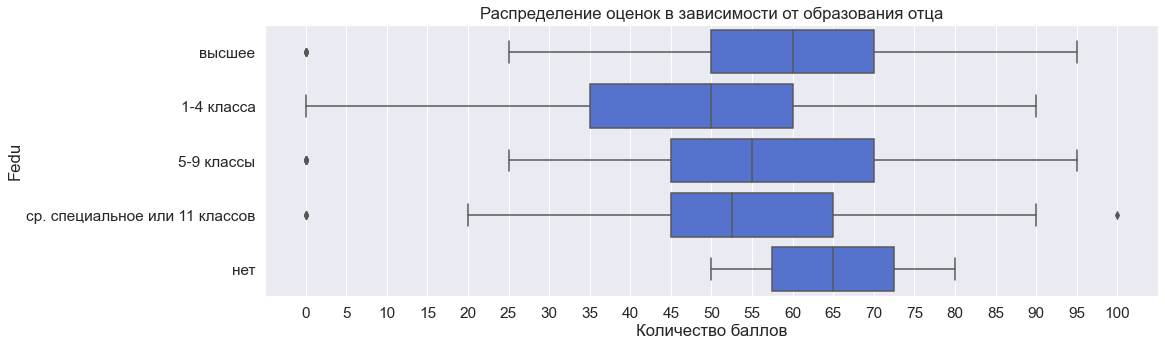

In [86]:
data.Fedu = data.Fedu.apply(lambda x: 'нет' if x == 0 else
                            '1-4 класса' if x == 1 else
                            '5-9 классы' if x == 2 else
                            'ср. специальное или 11 классов' if x == 3 else
                            'высшее' if x == 4 else x)
boxplot_for_cat(data.Fedu, 'образования отца', figsize=(16, 5))

Видно, что есть различие в оценках в разных случаях. Поэтому заполнять пустые строчки на мой взгляд не самая удачная идея. Оставим пропуски в отдельной группе "no_info". Добавим данный признак в список признаков для последующей работы

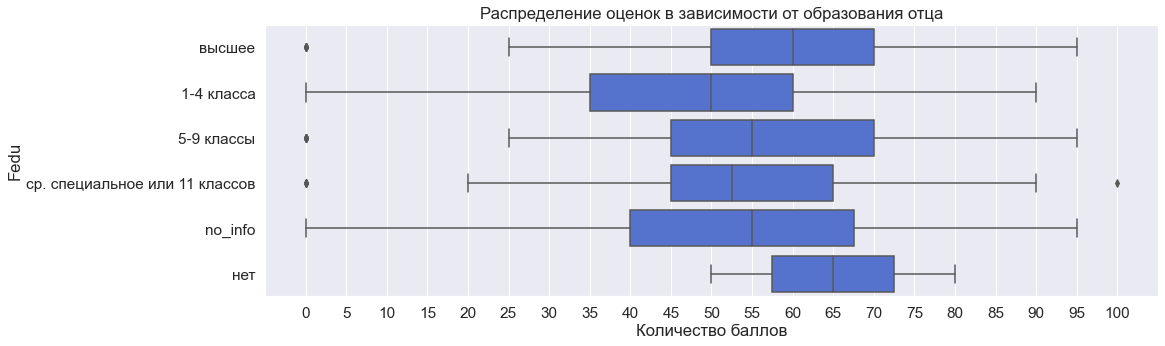

In [87]:
no_info("Fedu")
features_for_the_model.append('Fedu')
boxplot_for_cat(data.Fedu, 'образования отца', figsize=(16, 5))

## Mjob

Всего у 19 учеников не известно о работе матери


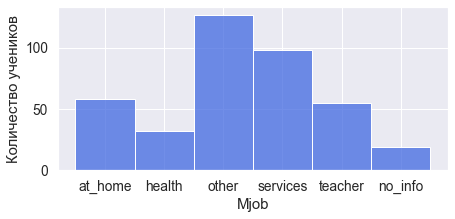

In [88]:
histplot_for_cat(data.Mjob, bins=6, figsize=(7, 3))
print('Всего у {} учеников не известно о работе матери'.format(
    len(data[data.Mjob == 'no_info'])))

Отнесём отсутствующие данные в категорию "другая" работа

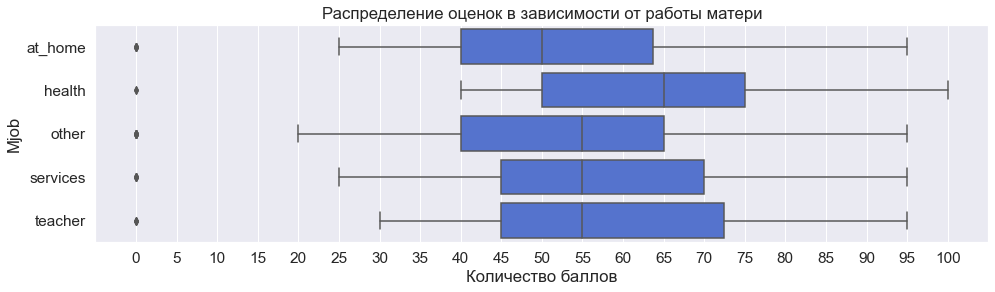

In [89]:
data.Mjob = data.Mjob.apply(lambda x: 'other' if x == 'no_info' else x)
boxplot_for_cat(data.Mjob, 'работы матери', figsize=(16, 4))

Видим, что можно заметим небольшую зависимость оценки от работы матери, поэтому внесём эту характеристику к список признаков

In [90]:
features_for_the_model.append('Mjob')

## Fjob

Всего у 36 учеников не известно о работе отца


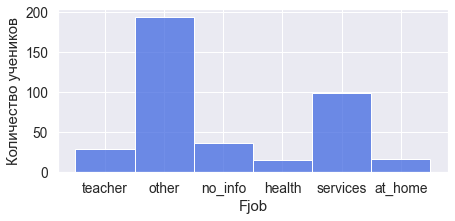

In [91]:
histplot_for_cat(data.Fjob, bins=6, figsize=(7, 3))
print('Всего у {} учеников не известно о работе отца'.format(
    len(data[data.Fjob == 'no_info'])))

Отсутсвуют 36 данных о работе отца. Отнесём данные в "другие"

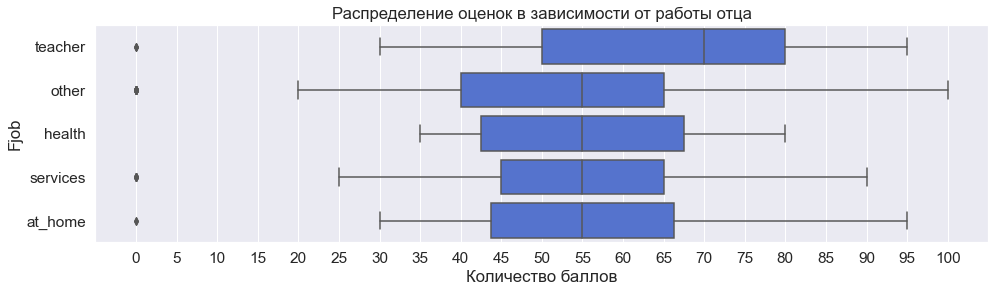

In [92]:
data.Fjob = data.Fjob.apply(lambda x: 'other' if x == 'no_info' else x)
boxplot_for_cat(data.Fjob, 'работы отца', figsize=(16, 4))

## reason

Всего у 17 учеников не известно о причине выбора школы


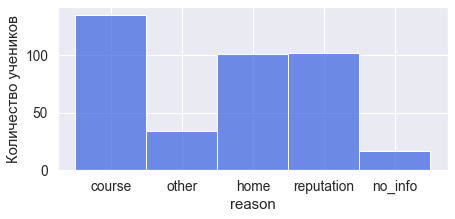

In [93]:
histplot_for_cat(data.reason, bins=6, figsize=(7, 3))
print('Всего у {} учеников не известно о причине выбора школы'.format(
    len(data[data.reason == 'no_info'])))

Отсутствуют 17 данных. Так же отнесём их в категорию "другие"

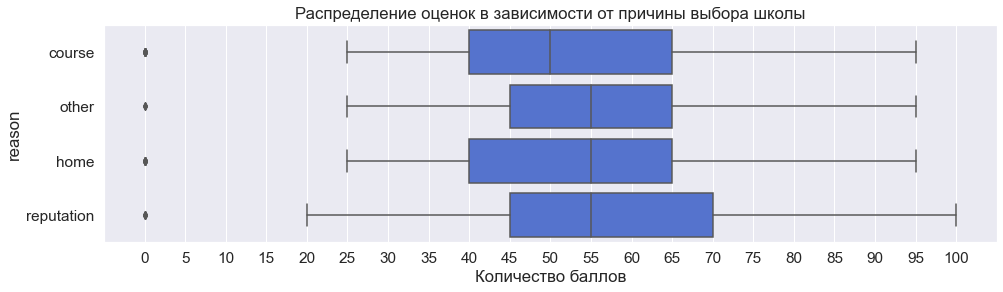

In [94]:
data.reason = data.reason.apply(lambda x: 'other' if x == 'no_info' else x)
boxplot_for_cat(data.reason, 'причины выбора школы', figsize=(16, 4))

Судя по boxplot зависимости оценко от причины не наблюдается

## guardian 

Всего у 31 учеников не известно о том, кто является опекуном


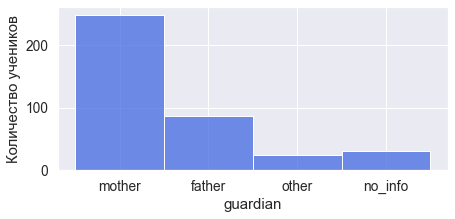

In [95]:
histplot_for_cat(data.guardian, bins=6, figsize=(7, 3))
print('Всего у {} учеников не известно о том, кто является опекуном'.format(
    len(data[data.guardian == 'no_info'])))

Нет информации о 7.8% опекунах учеников  Это большой процент, в группе "другие" всего 7.1%, поэтому оставлю эти данные в группе "без информации"

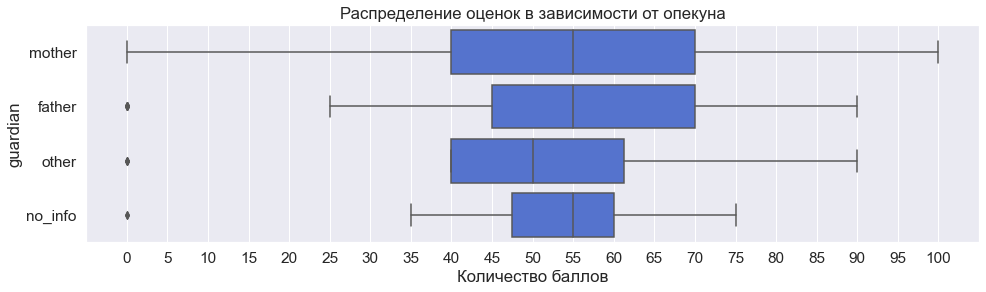

In [96]:
boxplot_for_cat(data.guardian, 'опекуна', figsize=(16, 4))

Проследить какую-либо зависимость тяжело

## traveltime 

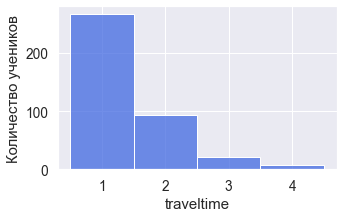

In [97]:
histplot_for_cat(data.traveltime, bins=4, figsize=(5, 3))

Выше уже заменил пустые данные на медиану этого столбца. Дополнительно переименую данные, для более комфортного восприятия

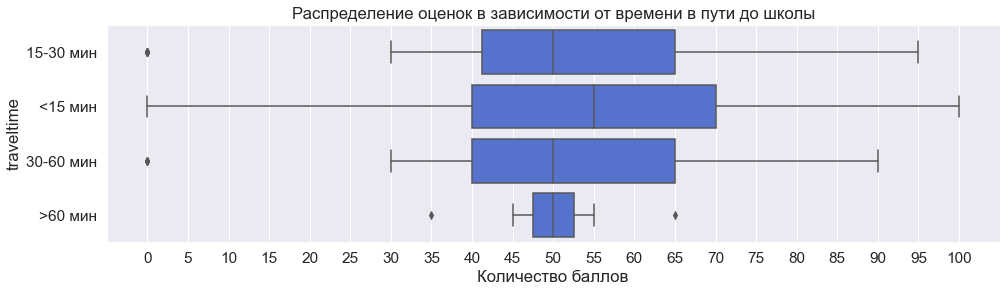

In [98]:
data.traveltime = data.traveltime.apply(lambda x: '<15 мин' if x == 1 else
                                        '15-30 мин' if x == 2 else
                                        '30-60 мин' if x == 3 else
                                        '>60 мин')
boxplot_for_cat(data.traveltime, 'времени в пути до школы', figsize=(16, 4))

Проследить зависимость целевой переменой от времени нельзя

## studytime 

Всего у 7 учеников не известно о учебном времени вне школы


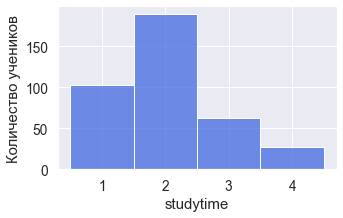

In [99]:
histplot_for_cat(data.studytime, bins=4, figsize=(5, 3))
print('Всего у {} учеников не известно о учебном времени вне школы'.format(
    data.studytime.isnull().sum()))

Проверим медиану в этом столбце, и если это целое число - заменим эти пропуски медианой и дополнительно переименую для комфортного восприятия

In [100]:
data.studytime.median()

2.0

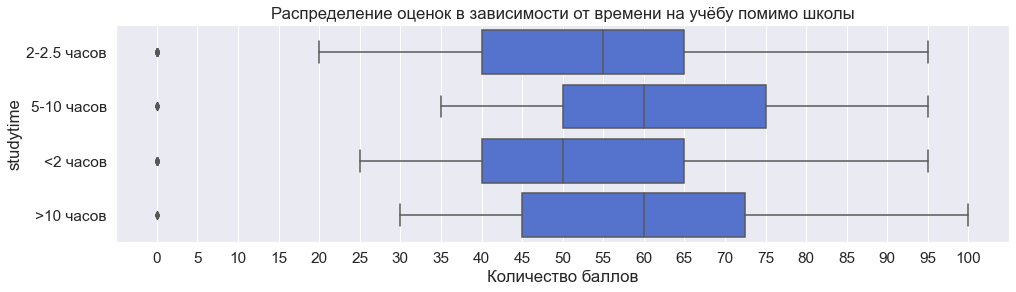

In [101]:
nan_to_median('studytime')
data.studytime = data.studytime.apply(lambda x: '<2 часов' if x == 1 else
                                      '2-2.5 часов' if x == 2 else
                                      '5-10 часов' if x == 3 else
                                      '>10 часов')
boxplot_for_cat(
    data.studytime, 'времени на учёбу помимо школы', figsize=(16, 4))

Пока внесём данный признак в список важных признак, в последующем рассмотрим его внимательнее

In [102]:
features_for_the_model.append('studytime')

## failures

Всего у 22 учеников не известно о внеучебных неудачах


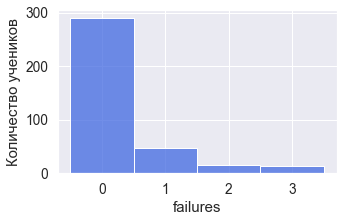

In [103]:
histplot_for_cat(data.failures, figsize=(5, 3))
print('Всего у {} учеников не известно о внеучебных неудачах'.format(
    data.failures.isnull().sum()))

Заменим эти пропуски модой (0.0, которая составляет более 75%).

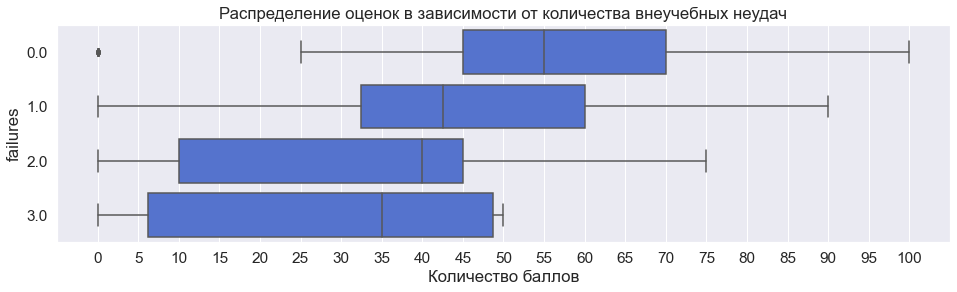

In [104]:
nan_to_mode('failures')
boxplot_for_cat(data.failures, 'количества внеучебных неудач', figsize=(16, 4))

Внесем данный признак в важные, в последующем рассмотрим его поподробнее

In [105]:
features_for_the_model.append('failures')

## schoolsup и famsup 

Всего у 9 учеников не известно о дополнительной образовательно поддержке
Всего у 38 учеников не известно о дополнительной семейной поддержке


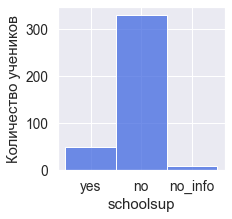

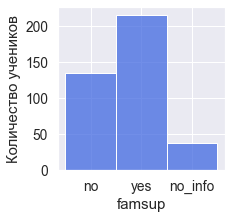

In [106]:
histplot_for_cat(data.schoolsup, figsize=(3, 3))
print('Всего у {} учеников не известно о дополнительной образовательно поддержке'.format(
    len(data[data.schoolsup == 'no_info'])))
histplot_for_cat(data.famsup, bins=4, figsize=(3, 3))
print('Всего у {} учеников не известно о дополнительной семейной поддержке'.format(
    len(data[data.famsup == 'no_info'])))

В первом случае отсутствуют данные о 9-ти учениках, во втором - у 38. Объединим данные из этих столбиков в один, в котором будет информация об общей образовательной поддержки (не важно, семейной или другой дополнительной) 

In [51]:
# Создадим новый столбец просуммировав два столбца
data['support'] = data['schoolsup'] + data['famsup']

# Изменяем в нём данные на "yes", "no" или "no_info" (да, немного странный способ XD)
data.support = data.support.apply(lambda x: 'yes' if 'yes' in x              
                                  else 'no_info' if x == 'no_infono_info'
                                  else 'no')

data.drop('schoolsup', axis=1, inplace=True)  # Удаляем столбец schoolsup
data.drop('famsup', axis=1, inplace=True)     # Удаляем столбец famsup

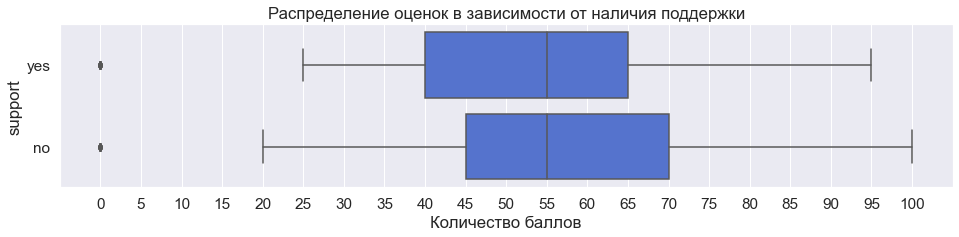

In [52]:
boxplot_for_cat(data.support, "наличия поддержки")

Не удаётся визуально проследить зависимость

## paid, activities, nursery, higher, internet и romantic

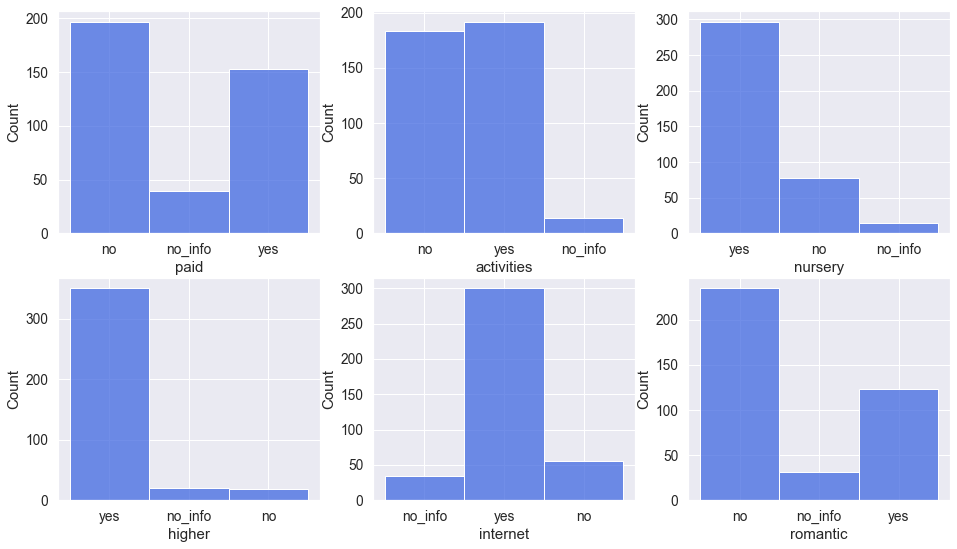

In [111]:
bin_columns = ['paid', 'activities', 'nursery',
               'higher', 'internet', 'romantic']

fig, axes = plt.subplots(2, 3, figsize=(16, 9))
for i, column in enumerate(bin_columns):
    plt.subplot(2, 3, i+1)
    sns.set(font_scale=1.4)
    sns.histplot(data[column], color='royalblue')

Во всех этих столбцах есть всего два точных варианта (yes или no) и те ученики, для которых данные не известны (no_info).
Лучше оставлю этот третий вариант, чтобы сильно не менялось соотношение между yes и no, что исказит результаты корреляции с score. (В принципе можно было в столбце nursery заменить no_info на моду (yes), но мною решено, что раз остальные не трогаю, то и этот не трогать будет правильнее)

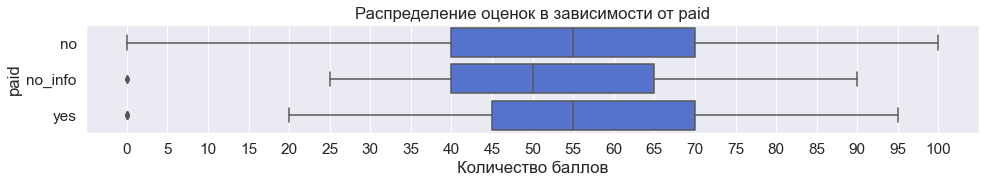

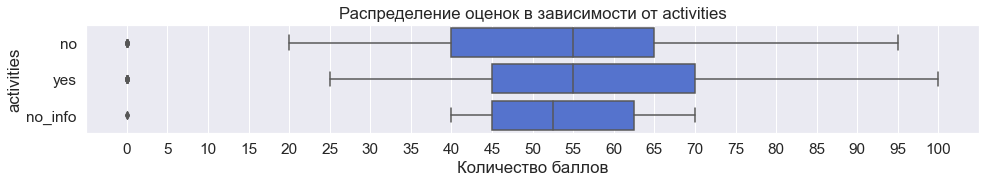

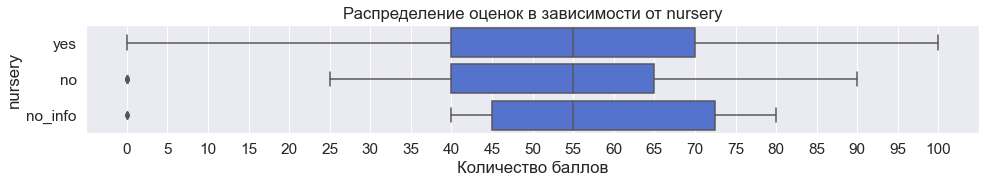

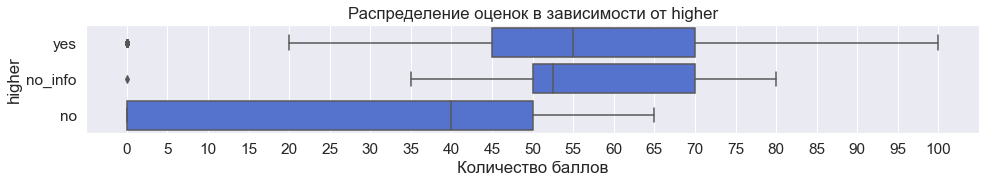

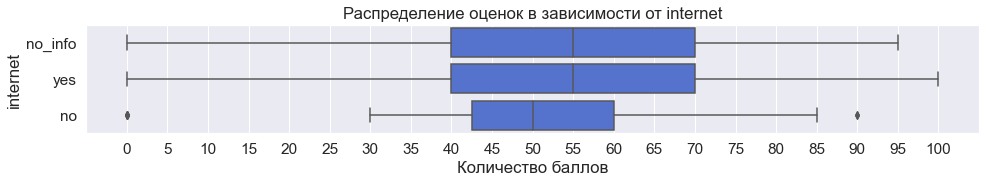

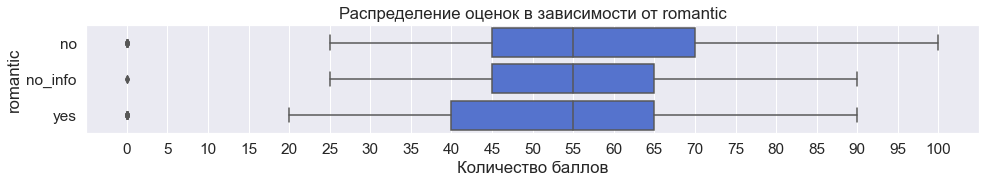

In [54]:
# Посмотрим на распределение оценов в зависимости от этих признаков
for column in bin_columns:
    sns.set(font_scale=1.4)
    plt.subplots(figsize=(16, 2))
    plt.xticks(ticks=range(0, 101, 5))
    plt.title('Распределение оценок в зависимости от ' + column)
    sns.boxplot(y=data[column], x=data.score, color='royalblue', orient='h')
    plt.xlabel('Количество баллов')

Зависимость оценки можно заменить только от желания получить высшее образование, поэтому этот признак добавляем в список

In [55]:
features_for_the_model.append('higher')

## famrel

Всего у 27 учеников не известно о семейных отношениях


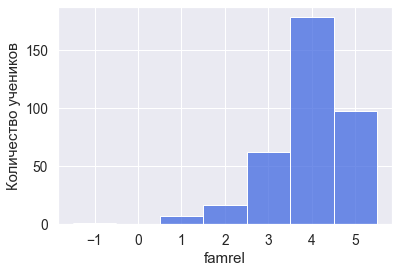

In [56]:
histplot_for_cat(data.famrel, figsize=(6, 4))
print('Всего у {} учеников не известно о семейных отношениях'.format(
    data.famrel.isnull().sum()))

Отсутствует 27 данных, и одно не верное (-1). Можно предположить, что это опечатка, поэтому заменим на 1.
А пропуски заменим модой.

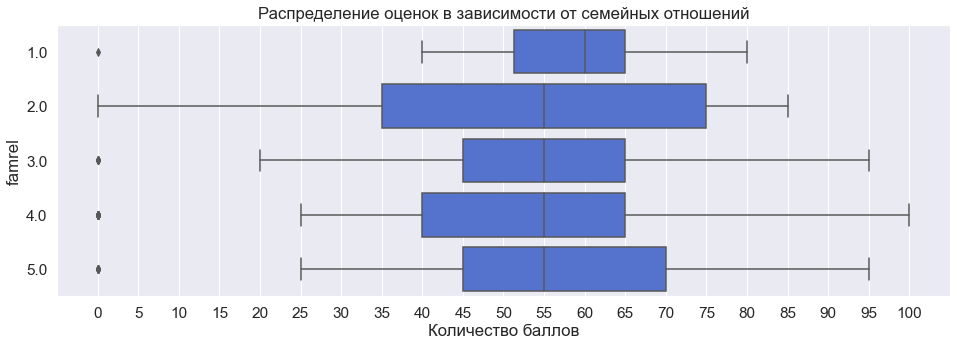

In [57]:
data.loc[(data[data['famrel'] == -1].index), 'famrel'] = 1
nan_to_mode('famrel')
boxplot_for_cat(data.famrel, "семейных отношений", figsize=(16, 5))

Визуально трудно определить зависимость

## freetime

Всего у 9 учеников не известно о свободном времени


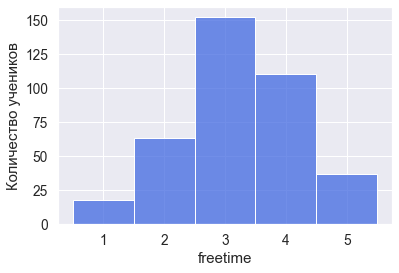

In [58]:
histplot_for_cat(data.freetime, figsize=(6, 4))
print('Всего у {} учеников не известно о свободном времени'.format(
    data.freetime.isnull().sum()))

Отсутствует 9 данных. Заменим пропуски на медианные данные (которые так же являются модой)

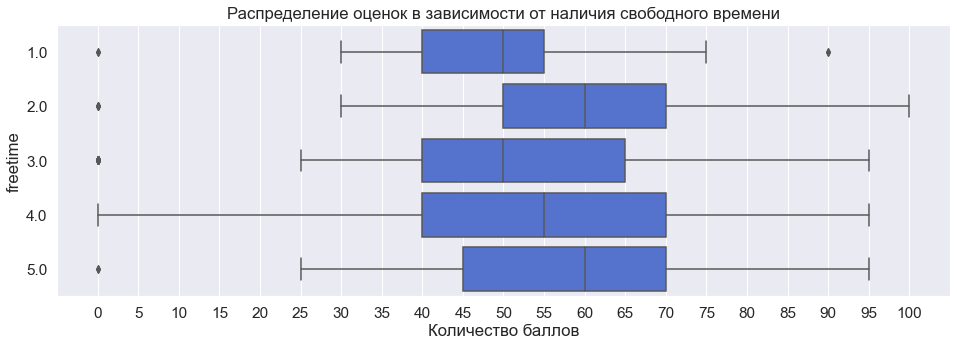

In [59]:
nan_to_median('freetime')
boxplot_for_cat(data.freetime, "наличия свободного времени", figsize=(16, 5))

Зависимость оценки от свободного времени трудно проследить

## goout

Всего у 7 учеников не известно о проведенном времени с друзьями


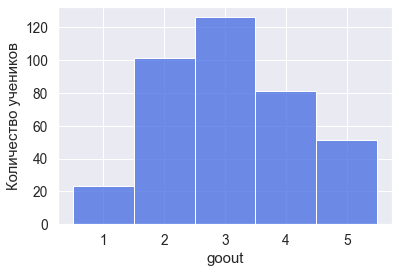

In [60]:
histplot_for_cat(data.goout, figsize=(6, 4))
print('Всего у {} учеников не известно о проведенном времени с друзьями'.format(
    data.goout.isnull().sum()))

Отсутствует 7 данных. Посмотрим внимательно на данные связанные со временем об этих учениках.

In [61]:
data[data['goout'].isnull()][['traveltime', 'studytime', 'freetime']]

,traveltime,studytime,freetime
89,<15 мин,2-2.5 часов,1.0
92,<15 мин,2-2.5 часов,3.0
200,<15 мин,2-2.5 часов,3.0
202,<15 мин,2-2.5 часов,4.0
221,<15 мин,5-10 часов,3.0
241,<15 мин,2-2.5 часов,3.0
322,<15 мин,5-10 часов,3.0


Все они тратят мало времени на дорогу до учёбы. На основе двух других колонок сделаем предположение о их времени с друзьями и заполним пропуски. Разумеется это время не может превышать свободное время

In [62]:
data.loc[89, 'goout'] = 1.0
data.loc[92, 'goout'] = 3.0
data.loc[200, 'goout'] = 3.0
data.loc[202, 'goout'] = 4.0
data.loc[221, 'goout'] = 2.0
data.loc[241, 'goout'] = 3.0
data.loc[322, 'goout'] = 2.0

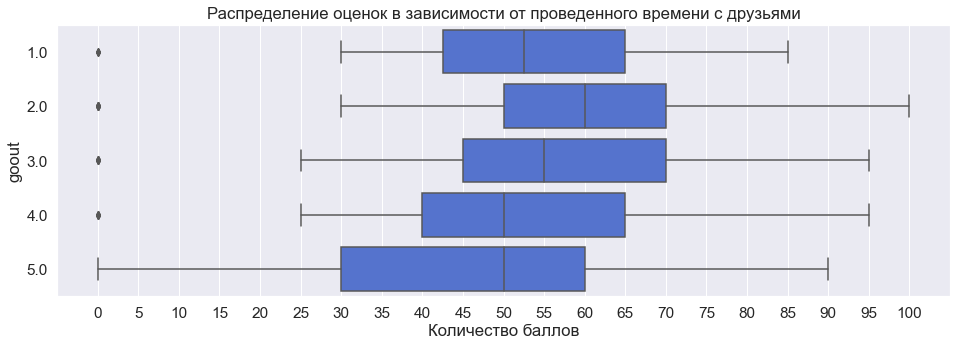

In [63]:
boxplot_for_cat(data.goout, "проведенного времени с друзьями", figsize=(16, 5))

Визуально тяжело проследить зависимость оценки от проведённого времени с друзьями

## health

Всего у 15 учеников не известно о состоянии здоровья


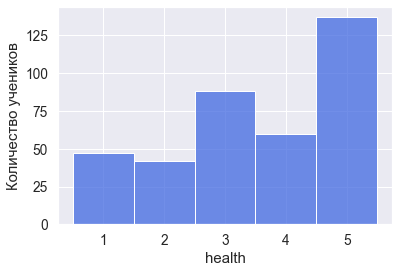

In [64]:
histplot_for_cat(data.health, figsize=(6, 4))
print('Всего у {} учеников не известно о состоянии здоровья'.format(
    data.health.isnull().sum()))

Отсутствуют 15 значений. На мой взгляд заполнять пропуски модой или медианой тут не лучший вариант. У более чем 75% учеников здоровье среднее или выше (от 3 до 5). Поэтому пропуски заменим средним именно по этой категории (т. е. 4)

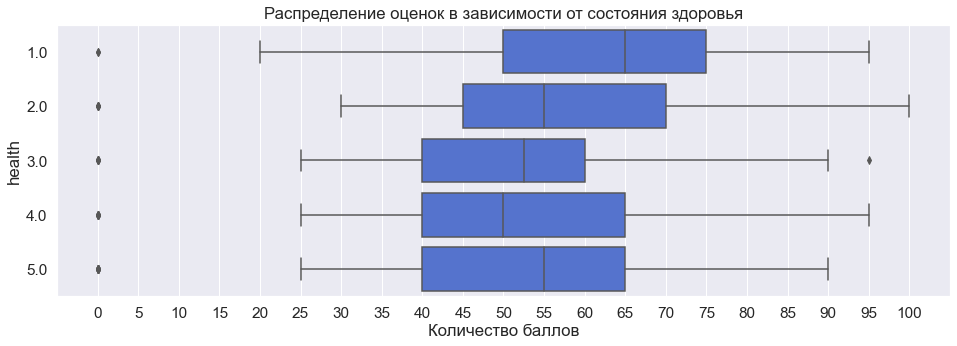

In [65]:
data.health.fillna(4, inplace=True)
boxplot_for_cat(data.health, "состояния здоровья", figsize=(16, 5))

Визуально не получается увидеть явной зависимость целевой переменной от состояния здоровья

## absences

25-й перцентиль: 0.0 | 75-й перцентиль: 8.0 | IQR: 8.0 |  Границы выбросов: [-12.0, 20.0].
Выбросов, согласно IQR: 17 | 4.37%
Всего у 11 учеников не известно количество пропущеных занятий


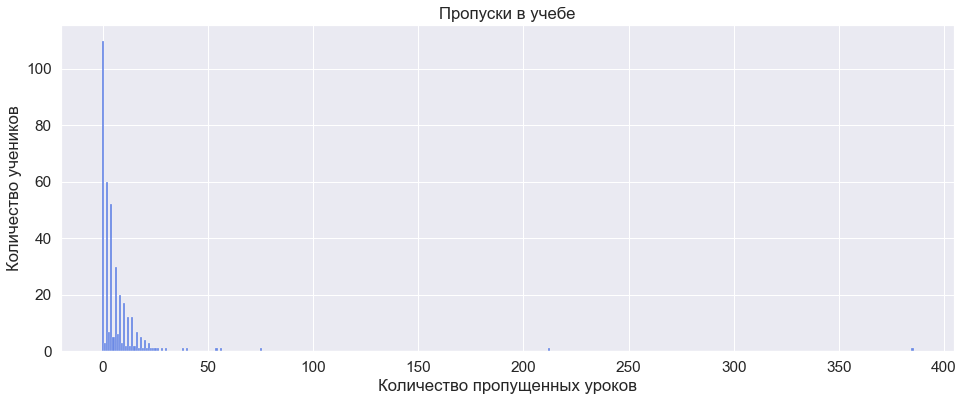

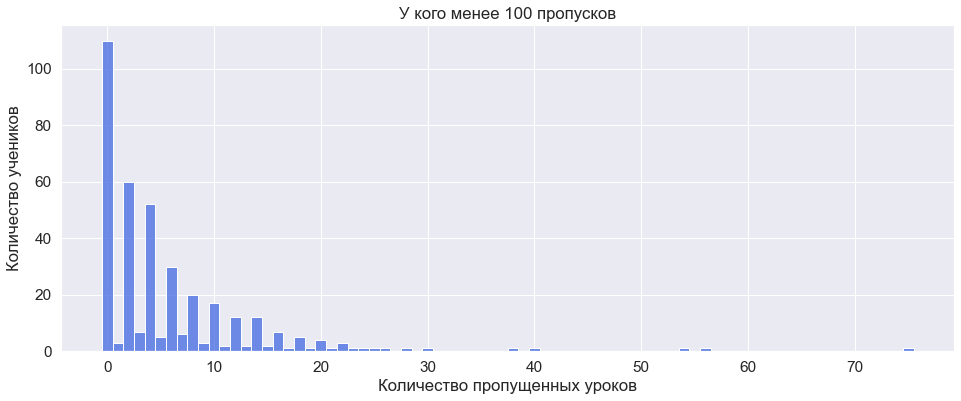

In [66]:
IQR_for_column('absences')
print('Всего у {} учеников не известно количество пропущеных занятий'.format(
    data.absences.isnull().sum()))

# Посмотрим на распределение пропущенных занятий
sns.set(font_scale=1.4)
plt.figure(figsize=(16, 6))
plt.title('Пропуски в учебе')
plt.xlabel('Количество пропущенных уроков')
plt.ylabel('Количество учеников')
sns.histplot(data.absences, discrete=True, color='royalblue')
plt.show()

# Внимательнее на количество учеников, у которых меньше 100 пропусков
sns.set(font_scale=1.4)
plt.figure(figsize=(16, 6))
plt.title('У кого менее 100 пропусков')
plt.xlabel('Количество пропущенных уроков')
plt.ylabel('Количество учеников')
sns.histplot(data[data.absences < 100].absences,
             discrete=True, 
             color='royalblue')
plt.show()

Отсутствует 11 значений. Судя по построенной гистограмме есть выбросы (и по IQR они есть), но чисто теоретически может быть столько много пропусков у учеников, поэтому эти данные нельзя удалять. Посмотрим внимательно на строчки, в которых есть пропуски этого признака

In [67]:
data[data['absences'].isnull()]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score,support
24,GP,F,15,За городом,больше трёх,Together,5-9 классы,высшее,services,health,course,mother,<15 мин,5-10 часов,0.0,yes,yes,yes,yes,yes,no,4.0,3.0,2.0,5.0,NaN,40.0,yes
101,GP,M,16,Город,больше трёх,Together,высшее,высшее,services,teacher,other,father,<15 мин,5-10 часов,0.0,no,yes,yes,yes,yes,yes,4.0,4.0,3.0,4.0,NaN,85.0,yes
120,GP,F,15,Город,больше трёх,Together,1-4 класса,5-9 классы,at_home,other,course,mother,<15 мин,2-2.5 часов,0.0,no,no,no,yes,yes,no,3.0,2.0,3.0,1.0,NaN,75.0,no
129,GP,M,16,За городом,больше трёх,Together,высшее,высшее,teacher,teacher,course,mother,<15 мин,2-2.5 часов,0.0,yes,yes,yes,yes,yes,no,3.0,5.0,5.0,4.0,NaN,90.0,no
150,GP,M,18,Город,3 или меньше,Together,1-4 класса,1-4 класса,other,other,course,mother,<15 мин,<2 часов,3.0,no,no,yes,no,yes,yes,2.0,3.0,5.0,4.0,NaN,0.0,no
172,GP,M,17,Город,больше трёх,Together,высшее,высшее,teacher,other,reputation,mother,<15 мин,2-2.5 часов,0.0,yes,yes,yes,yes,yes,no,4.0,4.0,4.0,5.0,NaN,50.0,yes
215,GP,F,17,Город,3 или меньше,Together,ср. специальное или 11 классов,5-9 классы,other,other,reputation,mother,15-30 мин,2-2.5 часов,0.0,no_info,no,yes,yes,no_info,no,4.0,4.0,4.0,1.0,NaN,75.0,no
227,GP,M,17,Город,3 или меньше,no_info,5-9 классы,ср. специальное или 11 классов,services,services,reputation,father,<15 мин,2-2.5 часов,0.0,yes,no,no,no_info,yes,no,5.0,3.0,3.0,3.0,NaN,60.0,yes
254,GP,M,17,Город,больше трёх,Together,5-9 классы,1-4 класса,other,other,course,mother,<15 мин,<2 часов,0.0,no,no,no,yes,yes,no,4.0,4.0,2.0,5.0,NaN,60.0,no
265,GP,M,18,За городом,3 или меньше,no_info,ср. специальное или 11 классов,высшее,other,other,reputation,mother,15-30 мин,2-2.5 часов,0.0,yes,yes,yes,yes,yes,no,4.0,2.0,5.0,1.0,NaN,85.0,yes


На первый взгяд никакой зависимости от других колонок придумать нельзя и объяснить причину пропуска в данных очень трудно. Поэтому просто заменим  Nan на медиану (т.е. 4 занятия)

In [68]:
nan_to_median('absences')

# Перепроверка и выбор данных для последующего построения базовой модели

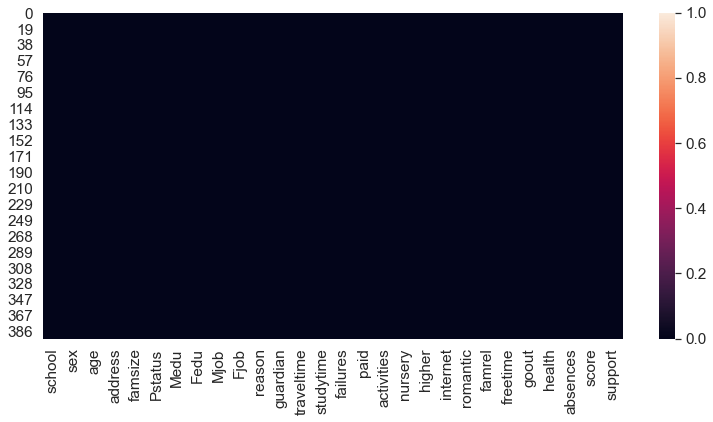

In [69]:
# Тепловая карта "пустых" значений (т.е. Nan). Проверяем, остались ли пропуски (белые черточки)
ax = plt.subplots(figsize=(13, 6))
ax = sns.heatmap(data.isnull(), vmax=1)

<AxesSubplot:>

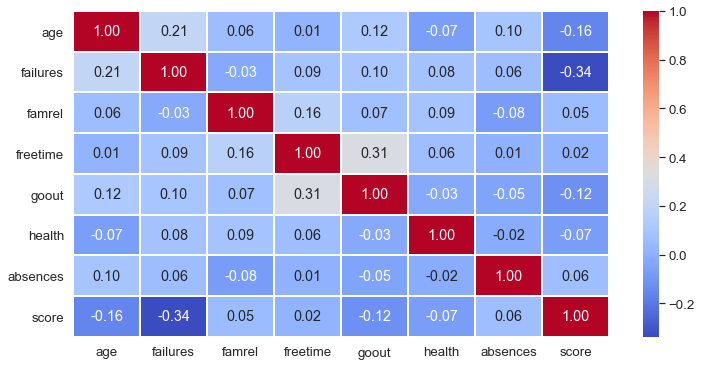

In [70]:
# Ещё раз смотрим корреляцию, после того, как избавились от пропусков
sns.set(font_scale=1.2)
plt.subplots(figsize=(12, 6))
sns.heatmap(data.corr(), annot=True, fmt='.2f',
            linewidths=0.1, cmap="coolwarm")

Видим, что столбов с одной и той же информацией нет, разные колонки коррелируются по разному, сильно низких значений корреляции не наблюдается. Для дальнейшей модели будем использовать все эти колонки (age, failures, famrel, freetime, goout, health, absences и score, разумеется). 

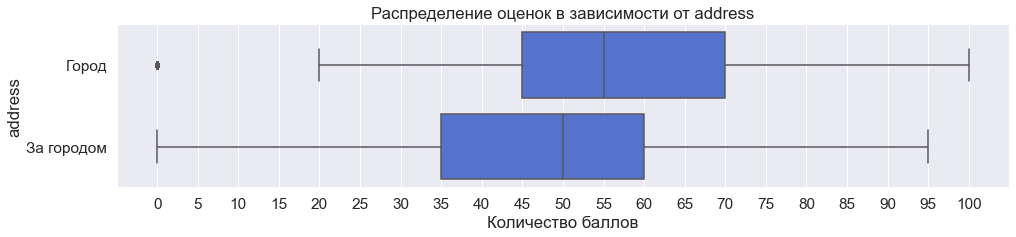

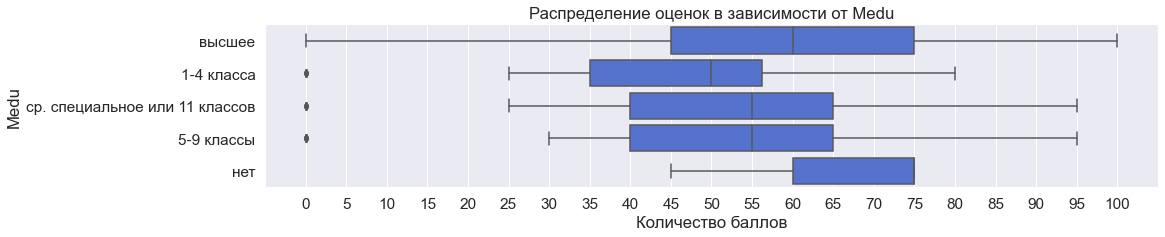

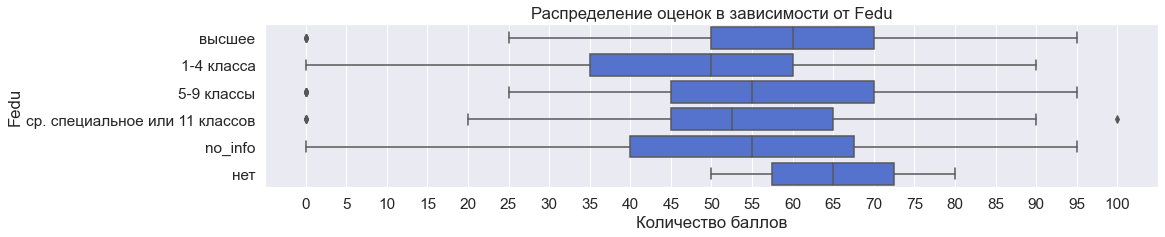

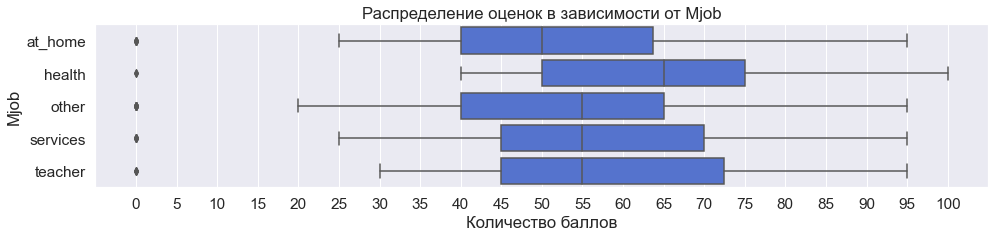

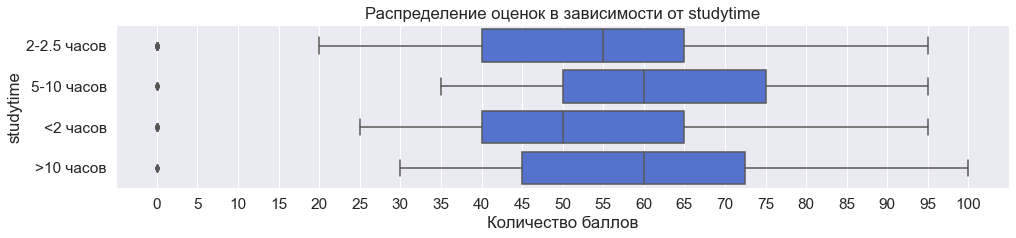

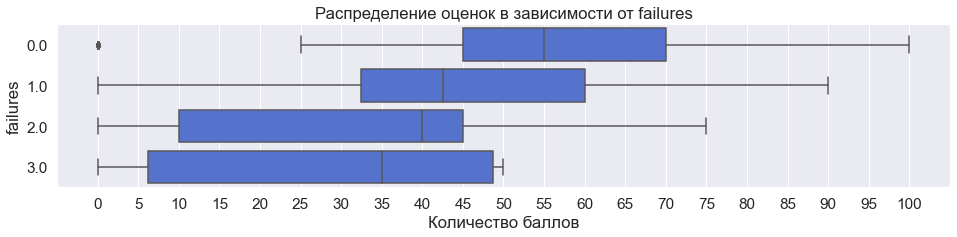

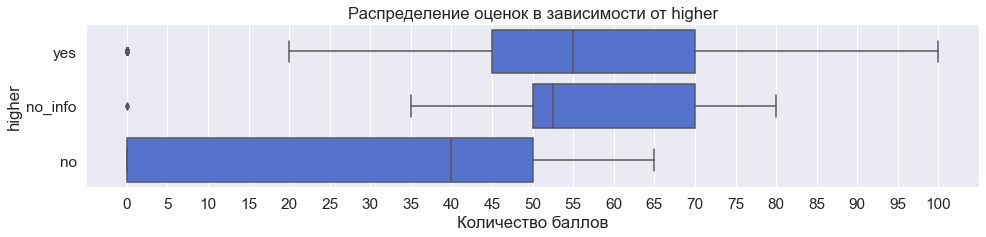

In [71]:
# Можно ещё раз посмотреть все boxplot для выбранных нами категориальных колонок по boxplot-ам
for col in features_for_the_model:
    boxplot_for_cat(data[col], col)

Глядя на boxplot-ы, можно оставить колонки adress, Medu, Fedu, Mjob, Fjob, failures и higher. Studytime визуально мало чем отличается (т. е. мало как влияет на score)

С помощью теста Стьюдента выясним для каких колонок могут быть найдены статистически значимые различия, которые визуально не выделяются

In [72]:
for col in ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian',
            'traveltime', 'studytime', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'support']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


# Итоги

Для дальнейшей работы по построению модели необходимо использовать все числовые колонки (age, failures, famrel,	freetime, goout, health, absences). Из номинативных переменных обязательно необходимо использовать те колонки, которые прошли тест Стьюдента.

В итоге имеем следующие данные для модели: 

In [73]:
data_for_model = data.loc[:, ['age', 'failures', 'famrel', 'freetime', 'goout', 'health', 'absences', 'address', 'Medu', 'Mjob',
                              'higher', 'romantic', 'score']]
data_for_model.head()

,age,failures,famrel,freetime,goout,health,absences,address,Medu,Mjob,higher,romantic,score
0,18,0.0,4.0,3.0,4.0,3.0,6.0,Город,высшее,at_home,yes,no,30.0
1,17,0.0,5.0,3.0,3.0,3.0,4.0,Город,1-4 класса,at_home,yes,no,30.0
2,15,3.0,4.0,3.0,2.0,3.0,10.0,Город,1-4 класса,at_home,yes,no_info,50.0
3,15,0.0,3.0,2.0,2.0,5.0,2.0,Город,высшее,health,yes,yes,75.0
4,16,0.0,4.0,3.0,2.0,5.0,4.0,Город,ср. специальное или 11 классов,other,yes,no,50.0


коротые могут быть дополненны колонками Fedu, Fjob, studytime

In [74]:
print('Первоначальный размер датасета: {}, размер итогового, отобранного для построения модели: {}'.format(
    df.shape, data_for_model.shape))

Первоначальный размер датасета: (395, 30), размер итогового: (389, 13)


**В результате проделанной работы по анализу данных было сделано следующее:**
- Удалены ненужные объекты, для которых не было значения целевой переменной;
- Подробно рассмотрены все признаки, построенны графици распределния и зависимости оценки от признаков;
- Отдельно для каждого признака был выбран индивидуальный метод заполнения пропущенных значений;
- Некоторые категориальные значения были переименнованы для удобства работы и понимания;
- Из 29-ти признаков было отобрано 11 для дальнейшего потенциального построения модели (и ещё 3 признака "взяты про запас"

В зависимости от методов, которые мы выберем для построения модели, с полученным датасетом необходимо будет ещё поработать. Нормализовать числовые переменные, стандартизовать (при необходимость). Часто категориальных признаков необходимо будет "перевести в dummy". На основании какой-то базовой модели сделать первоначальные выводы в какую сторону дальше работа, идеи для генерации новых признаков и т.д